# ConditionalGAN MLP MNIST

This notebook is for implementing [Conditional Generative Adversarial Network](https://arxiv.org/abs/1411.1784) with [Tensorflow](https://www.tensorflow.org). <br>
Network architecture will be `Multi-layer perceptron` and [MNIST data](http://yann.lecun.com/exdb/mnist/) will be used. 

Reference: [hwalsuklee's Github](https://github.com/hwalsuklee/tensorflow-generative-model-collections)

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

## Import Libraries

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import datetime
import os

## Parameters


In [3]:
img_size   = 28
data_size  = img_size**2

batch_size = 256
num_epoch  = 150

n_hidden = 256
n_latent = 100
n_condition = 10

learning_rate_g = 2e-4
learning_rate_d = 2e-4

show_result_epoch = 5

date_time = datetime.datetime.now().strftime("%Y%m%d-%H-%M-%S")

load_model = False
train_model = True

save_path = "./saved_models/" + date_time + "_" + algorithm
load_path = "./saved_models/20190809-11-04-47_CGAN_MLP_MNIST/model/model" 

## Import MNIST Dataset

Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = tf.keras.datasets.mnist.load_data(path='mnist.npz')

In [5]:
x_train = mnist[0][0]
y_train = mnist[0][1]
x_test  = mnist[1][0]
y_test  = mnist[1][1]

x_train = np.reshape(x_train, [-1, data_size])
x_test  = np.reshape(x_test, [-1, data_size])

print('x_train shape: {}'.format(x_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('x_test shape: {}'.format(x_test.shape))
print('y_test shape: {}'.format(y_test.shape))

x_train shape: (60000, 784)
y_train shape: (60000,)
x_test shape: (10000, 784)
y_test shape: (10000,)


## Generator

In [6]:
def Generator(x, c, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        xavier_init = tf.contrib.layers.xavier_initializer()
        
        x_concat = tf.concat([x, c], -1)
        
        # First hidden layer
        w1 = tf.get_variable('w1', [x_concat.get_shape()[1], n_hidden], initializer=xavier_init)
        b1 = tf.get_variable('b1', [n_hidden], initializer=xavier_init)

        h1 = tf.nn.leaky_relu(tf.matmul(x_concat,w1)+b1)   
        
        # Second hidden layer
        w2 = tf.get_variable('w2', [h1.get_shape()[1], n_hidden], initializer=xavier_init)
        b2 = tf.get_variable('b2', [n_hidden], initializer=xavier_init)

        h2 = tf.nn.leaky_relu(tf.matmul(h1,w2)+b2)   
        
        # Output layer
        w3 = tf.get_variable('w3', [h2.get_shape()[1], data_size], initializer=xavier_init)      
        b3 = tf.get_variable('b3', [data_size], initializer=xavier_init)
        
        output = tf.sigmoid(tf.matmul(h2, w3)+b3)
        
        return output

## Discriminator

In [7]:
def Discriminator(x, c, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        xavier_init = tf.contrib.layers.xavier_initializer()
        
        x_concat = tf.concat([x, c], -1)
        
        # First hidden layer
        w1 = tf.get_variable('w1', [x_concat.get_shape()[1], n_hidden], initializer=xavier_init)
        b1 = tf.get_variable('b1', [n_hidden], initializer=xavier_init)

        h1 = tf.nn.leaky_relu(tf.matmul(x_concat,w1)+b1)
        
        # Second hidden layer
        w2 = tf.get_variable('w2', [h1.get_shape()[1], n_hidden], initializer=xavier_init)
        b2 = tf.get_variable('b2', [n_hidden], initializer=xavier_init)

        h2 = tf.nn.leaky_relu(tf.matmul(h1,w2)+b2)
              
        # Output layer
        wo = tf.get_variable('wo', [h2.get_shape()[1], 1], initializer=xavier_init)      
        bo = tf.get_variable('bo', [1], initializer=xavier_init)      
        
        logit = tf.matmul(h2, wo)+bo
        output = tf.sigmoid(logit)

        return logit, output

## GAN

In [8]:
def GAN(x, c, z):
    # Generator
    G = Generator(z, c)
    
    # Discriminator
    D_logit_real, D_out_real = Discriminator(x, c)
    D_logit_fake, D_out_fake = Discriminator(G, c, reuse=True)
    
    # get loss
    d_loss = -(tf.reduce_mean(tf.log(D_out_real + 1e-8)) + tf.reduce_mean(tf.log( (1-D_out_fake) + 1e-8)))
    g_loss = -tf.reduce_mean(tf.log(D_out_fake + 1e-8))

    return d_loss, g_loss , G

## Build Graph

In [9]:
x = tf.placeholder(tf.float32, shape=[None, data_size])
x_normalize = (tf.cast(x, tf.float32)) / (255.0)

z = tf.placeholder(tf.float32, shape=[None, n_latent])

c = tf.placeholder(tf.float32, shape=[None, n_condition])

is_training = tf.placeholder(tf.bool)

d_loss, g_loss, G = GAN(x_normalize, c, z) 

# optimization
trainable_variables = tf.trainable_variables()

trainable_variables_d = [var for var in trainable_variables if var.name.startswith('Discriminator')]
trainable_variables_g = [var for var in trainable_variables if var.name.startswith('Generator')]

train_step_d = tf.train.AdamOptimizer(learning_rate_d).minimize(d_loss, var_list=trainable_variables_d)
train_step_g = tf.train.AdamOptimizer(learning_rate_g).minimize(g_loss, var_list=trainable_variables_g)

## Initialization

In [10]:
# Initialize variables
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)

init = tf.global_variables_initializer()
sess.run(init)

## Load Model

In [ ]:
Saver = tf.train.Saver()

if load_model == True:
    Saver.restore(sess, load_path)

## Train

Epoch: 1 / G Loss: 9.81948 / D Loss: 0.00189


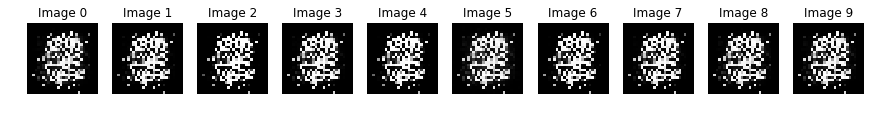

Epoch: 2 / G Loss: 8.91870 / D Loss: 0.00490
Epoch: 3 / G Loss: 10.32476 / D Loss: 0.00349
Epoch: 4 / G Loss: 14.49977 / D Loss: 0.00419
Epoch: 5 / G Loss: 7.51786 / D Loss: 0.00350


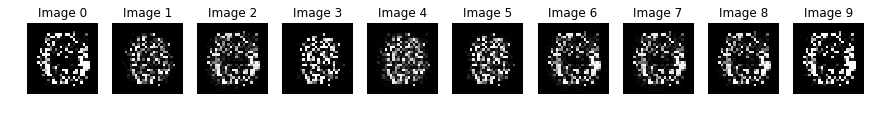

Epoch: 6 / G Loss: 8.02809 / D Loss: 0.01673
Epoch: 7 / G Loss: 8.57906 / D Loss: 0.00370
Epoch: 8 / G Loss: 8.77582 / D Loss: 0.00095
Epoch: 9 / G Loss: 8.21899 / D Loss: 0.00909
Epoch: 10 / G Loss: 10.00538 / D Loss: 0.00076


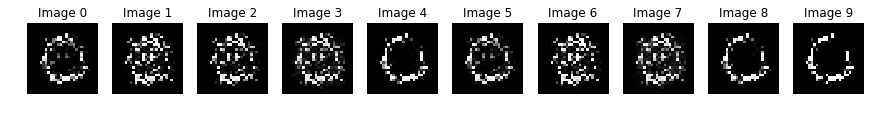

Epoch: 11 / G Loss: 8.03928 / D Loss: 0.01811
Epoch: 12 / G Loss: 9.03073 / D Loss: 0.00205
Epoch: 13 / G Loss: 9.29233 / D Loss: 0.00153
Epoch: 14 / G Loss: 11.15525 / D Loss: 0.01336
Epoch: 15 / G Loss: 11.04594 / D Loss: 0.00281


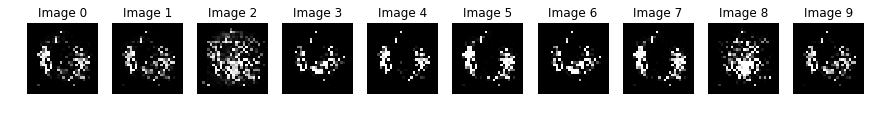

Epoch: 16 / G Loss: 7.91592 / D Loss: 0.02381
Epoch: 17 / G Loss: 10.00293 / D Loss: 0.00954
Epoch: 18 / G Loss: 9.45366 / D Loss: 0.00159
Epoch: 19 / G Loss: 11.45216 / D Loss: 0.03429
Epoch: 20 / G Loss: 11.59389 / D Loss: 0.00105


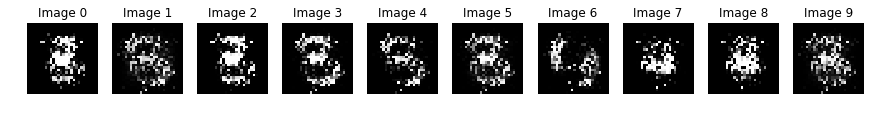

Epoch: 21 / G Loss: 9.90208 / D Loss: 0.00199
Epoch: 22 / G Loss: 10.23692 / D Loss: 0.02460
Epoch: 23 / G Loss: 12.28167 / D Loss: 0.00036
Epoch: 24 / G Loss: 10.25488 / D Loss: 0.00160
Epoch: 25 / G Loss: 12.07658 / D Loss: 0.00133


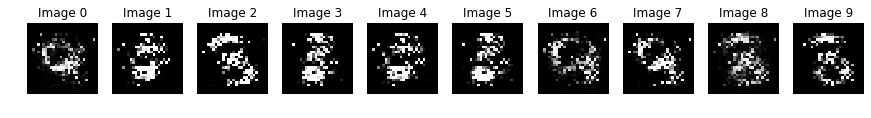

Epoch: 26 / G Loss: 13.41269 / D Loss: 0.03908
Epoch: 27 / G Loss: 10.67469 / D Loss: 0.00181
Epoch: 28 / G Loss: 10.45434 / D Loss: 0.00367
Epoch: 29 / G Loss: 10.30968 / D Loss: 0.00542
Epoch: 30 / G Loss: 12.19367 / D Loss: 0.00342


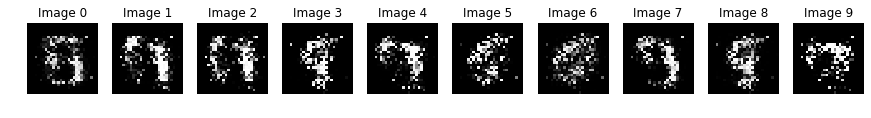

Epoch: 31 / G Loss: 10.36112 / D Loss: 0.00133
Epoch: 32 / G Loss: 10.81508 / D Loss: 0.00748
Epoch: 33 / G Loss: 11.27868 / D Loss: 0.01935
Epoch: 34 / G Loss: 10.68756 / D Loss: 0.01303
Epoch: 35 / G Loss: 9.16877 / D Loss: 0.06539


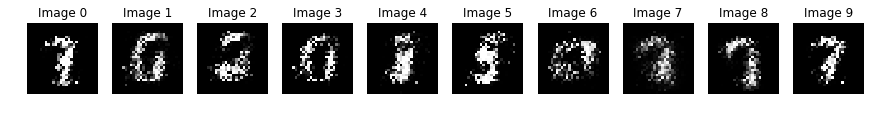

Epoch: 36 / G Loss: 9.86425 / D Loss: 0.01499
Epoch: 37 / G Loss: 9.89779 / D Loss: 0.04768
Epoch: 38 / G Loss: 10.59327 / D Loss: 0.05794
Epoch: 39 / G Loss: 9.72501 / D Loss: 0.00954
Epoch: 40 / G Loss: 10.01842 / D Loss: 0.00511


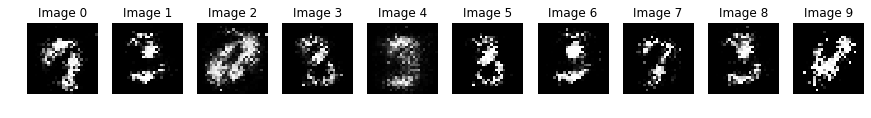

Epoch: 41 / G Loss: 8.36611 / D Loss: 0.05193
Epoch: 42 / G Loss: 9.07411 / D Loss: 0.00904
Epoch: 43 / G Loss: 9.04628 / D Loss: 0.06264
Epoch: 44 / G Loss: 9.32553 / D Loss: 0.08564
Epoch: 45 / G Loss: 8.90377 / D Loss: 0.04511


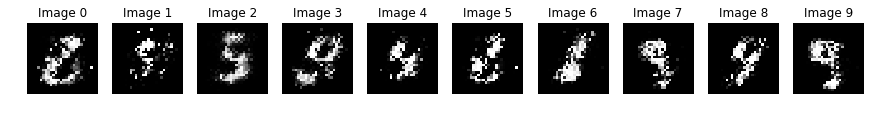

Epoch: 46 / G Loss: 8.16152 / D Loss: 0.01849
Epoch: 47 / G Loss: 8.15453 / D Loss: 0.09881
Epoch: 48 / G Loss: 6.20078 / D Loss: 0.17250
Epoch: 49 / G Loss: 8.04684 / D Loss: 0.07263
Epoch: 50 / G Loss: 6.89851 / D Loss: 0.03561


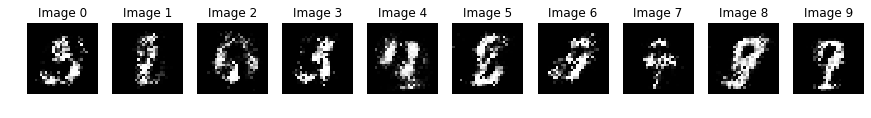

Epoch: 51 / G Loss: 7.39844 / D Loss: 0.15668
Epoch: 52 / G Loss: 7.64941 / D Loss: 0.09664
Epoch: 53 / G Loss: 6.37067 / D Loss: 0.10374
Epoch: 54 / G Loss: 5.97270 / D Loss: 0.13815
Epoch: 55 / G Loss: 6.30281 / D Loss: 0.17742


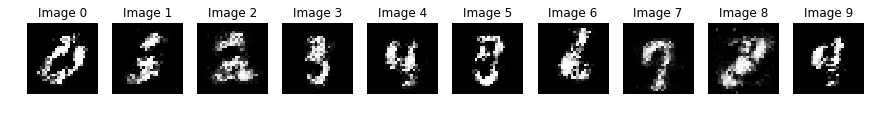

Epoch: 56 / G Loss: 5.94394 / D Loss: 0.10371
Epoch: 57 / G Loss: 5.73188 / D Loss: 0.12023
Epoch: 58 / G Loss: 6.33686 / D Loss: 0.26288
Epoch: 59 / G Loss: 5.70113 / D Loss: 0.21762
Epoch: 60 / G Loss: 5.25082 / D Loss: 0.16093


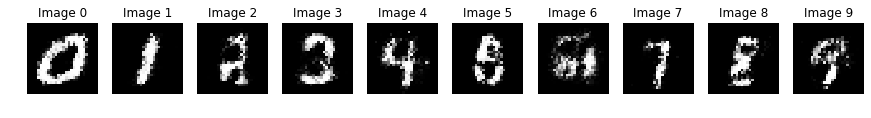

Epoch: 61 / G Loss: 4.90900 / D Loss: 0.23735
Epoch: 62 / G Loss: 5.24522 / D Loss: 0.11696
Epoch: 63 / G Loss: 6.47581 / D Loss: 0.21240
Epoch: 64 / G Loss: 4.71092 / D Loss: 0.16842
Epoch: 65 / G Loss: 4.77046 / D Loss: 0.26144


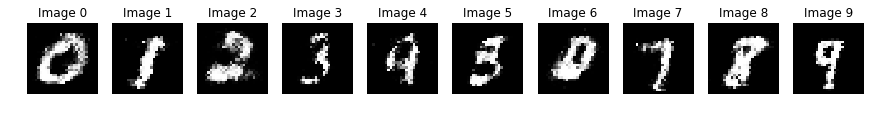

Epoch: 66 / G Loss: 4.54343 / D Loss: 0.14179
Epoch: 67 / G Loss: 5.54664 / D Loss: 0.26754
Epoch: 68 / G Loss: 4.65159 / D Loss: 0.18348
Epoch: 69 / G Loss: 4.10289 / D Loss: 0.41054
Epoch: 70 / G Loss: 4.72957 / D Loss: 0.15956


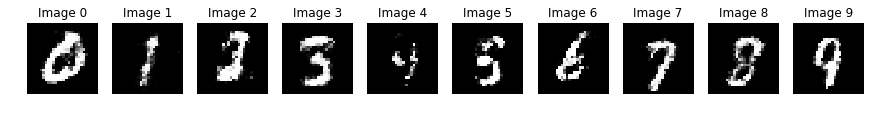

Epoch: 71 / G Loss: 5.45238 / D Loss: 0.20272
Epoch: 72 / G Loss: 4.67800 / D Loss: 0.20989
Epoch: 73 / G Loss: 4.72137 / D Loss: 0.25916
Epoch: 74 / G Loss: 4.50451 / D Loss: 0.15905
Epoch: 75 / G Loss: 4.21128 / D Loss: 0.19538


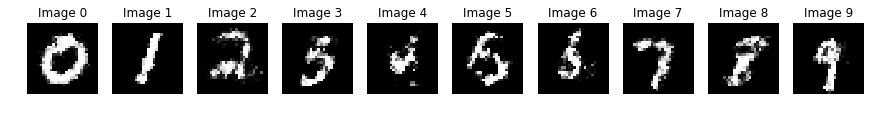

Epoch: 76 / G Loss: 4.30610 / D Loss: 0.18845
Epoch: 77 / G Loss: 4.08247 / D Loss: 0.28390
Epoch: 78 / G Loss: 3.35806 / D Loss: 0.41544
Epoch: 79 / G Loss: 4.00700 / D Loss: 0.24812
Epoch: 80 / G Loss: 3.95858 / D Loss: 0.28980


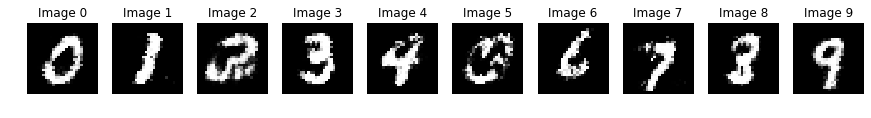

Epoch: 81 / G Loss: 3.85304 / D Loss: 0.35189
Epoch: 82 / G Loss: 3.94681 / D Loss: 0.24015
Epoch: 83 / G Loss: 2.87643 / D Loss: 0.36490
Epoch: 84 / G Loss: 3.69945 / D Loss: 0.28080
Epoch: 85 / G Loss: 3.25261 / D Loss: 0.22398


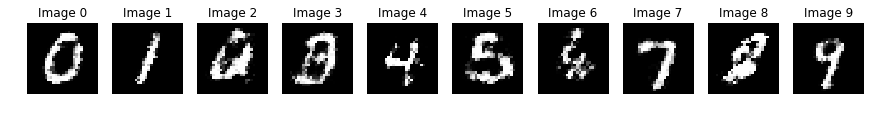

Epoch: 86 / G Loss: 2.92343 / D Loss: 0.30654
Epoch: 87 / G Loss: 4.03580 / D Loss: 0.43408
Epoch: 88 / G Loss: 3.58091 / D Loss: 0.55661
Epoch: 89 / G Loss: 3.28349 / D Loss: 0.33189
Epoch: 90 / G Loss: 3.25016 / D Loss: 0.39914


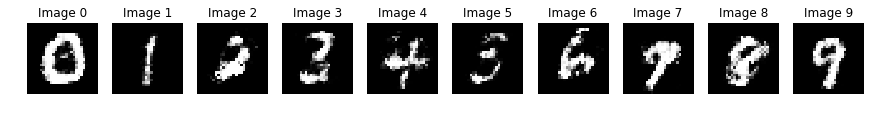

Epoch: 91 / G Loss: 3.58923 / D Loss: 0.34626
Epoch: 92 / G Loss: 3.30128 / D Loss: 0.30914
Epoch: 93 / G Loss: 3.04001 / D Loss: 0.52073
Epoch: 94 / G Loss: 3.08917 / D Loss: 0.38058
Epoch: 95 / G Loss: 3.19940 / D Loss: 0.32283


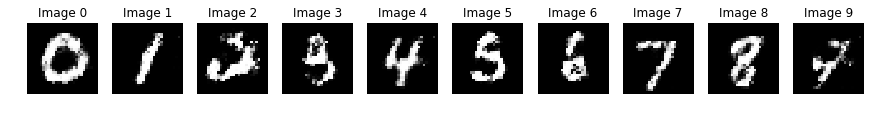

Epoch: 96 / G Loss: 2.78883 / D Loss: 0.41922
Epoch: 97 / G Loss: 2.84686 / D Loss: 0.45268
Epoch: 98 / G Loss: 2.87209 / D Loss: 0.39991
Epoch: 99 / G Loss: 2.75476 / D Loss: 0.60503
Epoch: 100 / G Loss: 3.47072 / D Loss: 0.43477


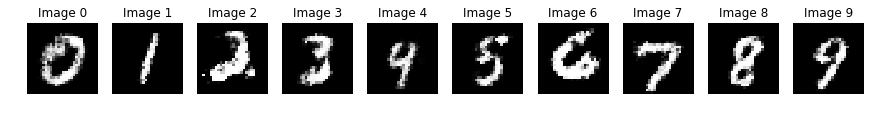

Epoch: 101 / G Loss: 2.28618 / D Loss: 0.83938
Epoch: 102 / G Loss: 2.51951 / D Loss: 0.52900
Epoch: 103 / G Loss: 2.67177 / D Loss: 0.45286
Epoch: 104 / G Loss: 2.83856 / D Loss: 0.57257
Epoch: 105 / G Loss: 2.99034 / D Loss: 0.48582


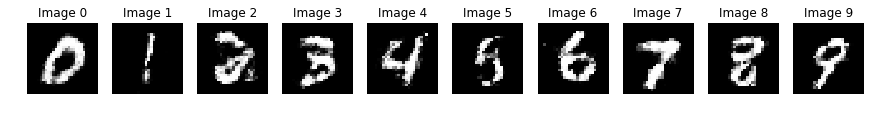

Epoch: 106 / G Loss: 2.61343 / D Loss: 0.55414
Epoch: 107 / G Loss: 2.92531 / D Loss: 0.45471
Epoch: 108 / G Loss: 2.54662 / D Loss: 0.49936
Epoch: 109 / G Loss: 2.60412 / D Loss: 0.46939
Epoch: 110 / G Loss: 2.42350 / D Loss: 0.68041


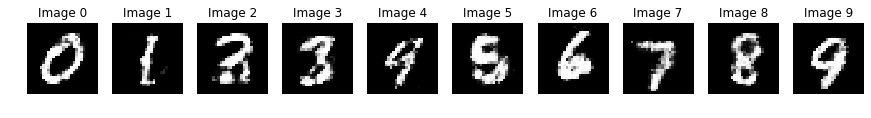

Epoch: 111 / G Loss: 2.72400 / D Loss: 0.51258
Epoch: 112 / G Loss: 2.34435 / D Loss: 0.66883
Epoch: 113 / G Loss: 2.51026 / D Loss: 0.52663
Epoch: 114 / G Loss: 2.53323 / D Loss: 0.54494
Epoch: 115 / G Loss: 2.09288 / D Loss: 0.64476


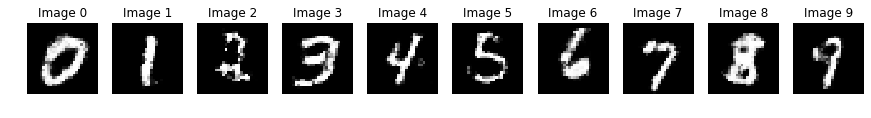

Epoch: 116 / G Loss: 2.26550 / D Loss: 0.49957
Epoch: 117 / G Loss: 2.65617 / D Loss: 0.47928
Epoch: 118 / G Loss: 2.61460 / D Loss: 0.67792
Epoch: 119 / G Loss: 2.58218 / D Loss: 0.55034
Epoch: 120 / G Loss: 2.08305 / D Loss: 0.80782


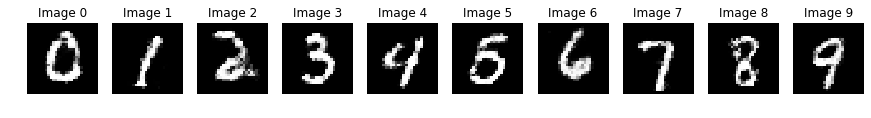

Epoch: 121 / G Loss: 2.39812 / D Loss: 0.54469
Epoch: 122 / G Loss: 2.05046 / D Loss: 0.66594
Epoch: 123 / G Loss: 2.40448 / D Loss: 0.79481
Epoch: 124 / G Loss: 2.34797 / D Loss: 0.70883
Epoch: 125 / G Loss: 2.20737 / D Loss: 0.66211


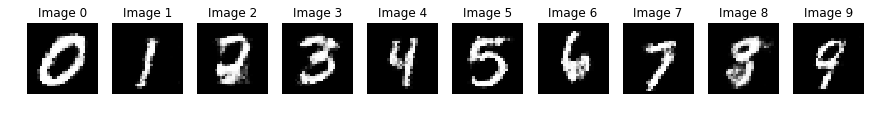

Epoch: 126 / G Loss: 2.26590 / D Loss: 0.88690
Epoch: 127 / G Loss: 2.35264 / D Loss: 0.56358
Epoch: 128 / G Loss: 2.01405 / D Loss: 0.81074
Epoch: 129 / G Loss: 2.24368 / D Loss: 0.73964
Epoch: 130 / G Loss: 2.36091 / D Loss: 0.62377


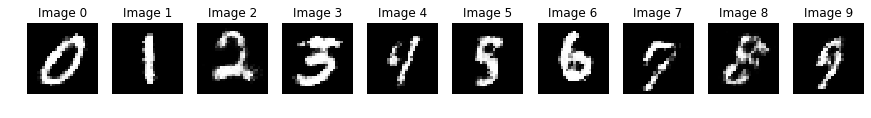

Epoch: 131 / G Loss: 2.23181 / D Loss: 0.67528
Epoch: 132 / G Loss: 2.33092 / D Loss: 0.48213
Epoch: 133 / G Loss: 1.94300 / D Loss: 0.65974
Epoch: 134 / G Loss: 2.15140 / D Loss: 0.65273
Epoch: 135 / G Loss: 2.31706 / D Loss: 0.63837


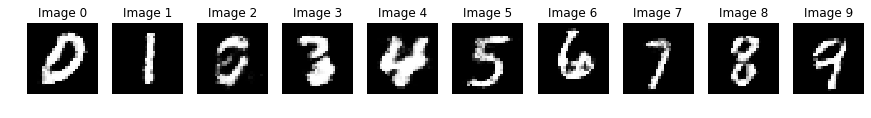

Epoch: 136 / G Loss: 2.19040 / D Loss: 0.60444
Epoch: 137 / G Loss: 2.05121 / D Loss: 0.55796
Epoch: 138 / G Loss: 2.28789 / D Loss: 0.68429
Epoch: 139 / G Loss: 2.54721 / D Loss: 0.58929
Epoch: 140 / G Loss: 2.11845 / D Loss: 0.60825


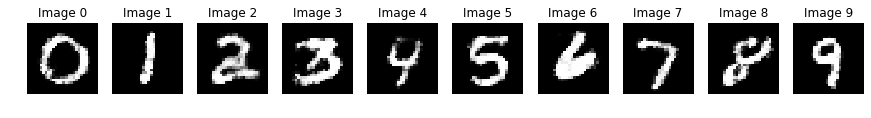

Epoch: 141 / G Loss: 2.19684 / D Loss: 0.73710
Epoch: 142 / G Loss: 2.07781 / D Loss: 0.70925
Epoch: 143 / G Loss: 2.54503 / D Loss: 0.66706
Epoch: 144 / G Loss: 2.21917 / D Loss: 0.56322
Epoch: 145 / G Loss: 1.95576 / D Loss: 0.74956


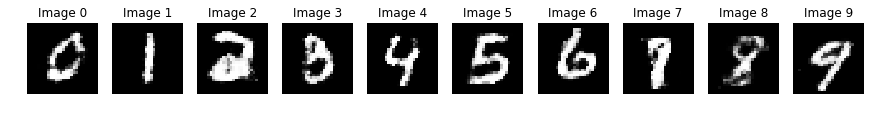

Epoch: 146 / G Loss: 2.49099 / D Loss: 0.57894
Epoch: 147 / G Loss: 2.10352 / D Loss: 0.67604
Epoch: 148 / G Loss: 2.28711 / D Loss: 0.67146
Epoch: 149 / G Loss: 2.23549 / D Loss: 0.71608
Epoch: 150 / G Loss: 2.06463 / D Loss: 0.56753


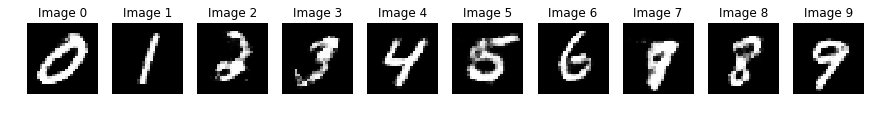

In [18]:
if train_model:
    # Training
    len_data = x_train.shape[0]

    for i in range(num_epoch):
        # Shuffle the data 
        random_idx = np.arange(len_data)
        np.random.shuffle(random_idx)

        # Making mini-batch
        for j in range(0, len_data, batch_size):
            if j + batch_size < len_data:
                batch_index = [j, j + batch_size]

                data_x_in  = x_train[random_idx[batch_index[0]:batch_index[1]],:]
                data_y_val = y_train[random_idx[batch_index[0]:batch_index[1]]]
            else:
                batch_index = [j, j + len_data-1]

                data_x_in  = x_train[random_idx[batch_index[0]:batch_index[-1]],:]
                data_y_val = y_train[random_idx[batch_index[0]:batch_index[-1]]]

            data_y_in = np.zeros([data_x_in.shape[0], n_condition])

            # Make one hot 
            for k in range(len(data_y_val)):
                data_y_in[k,data_y_val[k]] = 1

            sampled_z = np.random.uniform(-1, 1, size=(data_x_in.shape[0] , n_latent))

            # Run Optimizer!
            _, loss_d = sess.run([train_step_d, d_loss], feed_dict = {x: data_x_in, c: data_y_in, z: sampled_z})
            _, loss_g = sess.run([train_step_g, g_loss], feed_dict = {x: data_x_in, c: data_y_in, z: sampled_z})

            print("Batch: {} / {}".format(j, len_data), end="\r")

        # Print Progess
        print("Epoch: {} / G Loss: {:.5f} / D Loss: {:.5f}".format((i+1), loss_g, loss_d))

        # Show test images 
        n_test = 10

        z_test = np.random.uniform(-1, 1, size=(n_test, n_latent))
        c_test = np.zeros([n_test,n_condition])

        for j in range(n_test):
            c_test[j,j] = 1

        G_out = sess.run(G, feed_dict = {z: z_test,c: c_test, is_training: False})

        if i == 0 or (i+1) % show_result_epoch == 0:
            f, ax = plt.subplots(1,n_test, figsize=(15,15))
            for j in range(n_test):
                ax[j].imshow(G_out[j,:].reshape((img_size, img_size)), cmap = 'gray')
                ax[j].axis('off')
                ax[j].set_title('Image '+str(j))

        plt.show()

## Image Generation

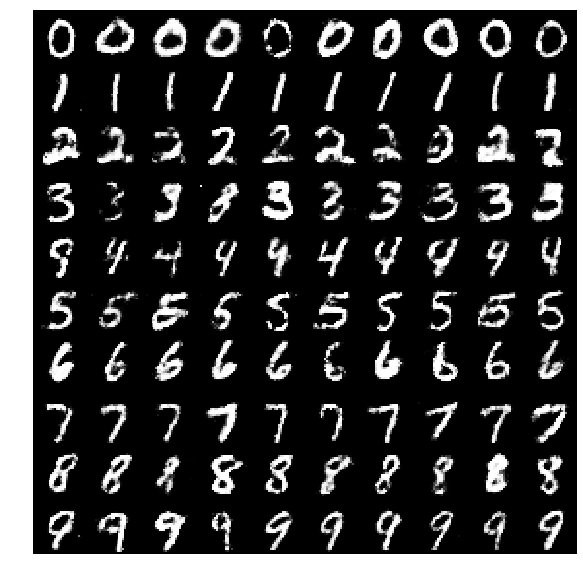

In [23]:
num_test = 10
    
img = np.zeros([img_size * num_test, img_size * num_test])

for i in range(num_test):
    for j in range(num_test):        
        c_result = np.zeros([1,n_condition])
        c_result[0, i] = 1
        
        z_result = np.random.uniform(-1, 1, size=(1, n_latent))
        
        G_result = sess.run(G, feed_dict = {z: z_result, c: c_result, is_training: False})
                
        img[i * img_size : (i + 1) * img_size, (j) * img_size : (j + 1) * img_size] = G_result.reshape((img_size, img_size))

plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

## Save Model

In [ ]:
os.mkdir(save_path)

Saver.save(sess, save_path + "/model/model")
print("Model is saved in {}".format(save_path + "/model/model"))